In [220]:
!python -m pip install h5py

   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   --------------------- ------------------ 1.6/3.0 MB 9.4 MB/s eta 0:00:01
   -------------------------------------- - 2.9/3.0 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 7.5 MB/s eta 0:00:00


In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from os import listdir
from pathlib import Path
import us
from tqdm import trange, tqdm
import h5py
import re

In [2]:
scenarios = ["current policy", "central high data center", "central"]

path = Path(f"C:/Users/SDotson/OneDrive - Union of Concerned Scientists/Documents/2025/reeds-project-data/2025.02.10_UCS_shape_outputs/shape_outputs/")

In [3]:
load_participation = pd.read_csv("https://raw.githubusercontent.com/NREL/ReEDS-2.0/refs/heads/main/hourlize/inputs/load/load_participation_factors_st_to_ba.csv")
county_to_ba = pd.read_csv("https://github.com/ucsusa/ReEDS-2.0/raw/refs/heads/main/inputs/county2zone.csv")

In [4]:
name_to_abbr = {state.name.lower():state.abbr for state in us.STATES_CONTINENTAL}

In [5]:
output_name = {'current policy':'EER_Current_UCS_load_hourly.h5',
               'central high data center':'EER_HighDC_UCS_load_hourly.h5',
               'central':'EER_Central_UCS_load_hourly.h5'}

# Attempt One

In [ ]:
combined['maryland'] = combined['district of columbia'] + combined['maryland']
combined = combined.drop(columns=['district of columbia'])
combined = combined.rename(columns=name_to_abbr)
combined_disagg = pd.DataFrame({int(row.ba.strip('p')):(combined[row.state].values\
         *load_participation.loc[load_participation['ba']==row.ba,'factor'].values[0]) 
 for row in county_to_ba.itertuples()})
combined_disagg['scenarios'] = combined['scenario'].reset_index(drop=True)

In [ ]:
combined_disagg['year'] = combined['year'].reset_index(drop=True)
combined_disagg['index'] = np.tile(np.arange(0,8760),6*3)
combined_disagg = combined_disagg.set_index(['scenarios','year','index'])

In [ ]:
combined_formatted = combined_disagg.reset_index()\
               .melt(id_vars=['scenarios','year','index'], 
                     value_vars=list(range(1,135)))\
               .pivot_table(values='value',
                            index=['scenarios','index','variable'],
                            columns=['year'])
combined_formatted.columns = [str(y) for y in range(2025, 2055, 5)]

In [86]:
combined_xarr = combined_formatted.to_xarray()

In [87]:
for scenario in scenarios:
    xds = combined_xarr.sel(scenarios=scenario)
    xds.to_netcdf(output_name[scenario])

In [ ]:
combined_xarr.to_netcdf(path="")

In [88]:
import xarray as xr

In [89]:
xds = xr.open_dataset('EER_Central_UCS_load_hourly.h5')

In [55]:
combined_disagg.to_xarray()

<xarray.Dataset> Size: 169MB
Dimensions:    (scenarios: 3, year: 6, index: 8760)
Coordinates:
  * scenarios  (scenarios) object 24B 'central' ... 'current policy'
  * year       (year) int64 48B 2025 2030 2035 2040 2045 2050
  * index      (index) int32 35kB 0 1 2 3 4 5 ... 8754 8755 8756 8757 8758 8759
Data variables: (12/134)
    1          (scenarios, year, index) float64 1MB 6.19e+03 ... 1.121e+04
    2          (scenarios, year, index) float64 1MB 3.485e+03 ... 6.31e+03
    3          (scenarios, year, index) float64 1MB 1.589e+03 ... 2.877e+03
    4          (scenarios, year, index) float64 1MB 623.3 593.8 ... 1.129e+03
    5          (scenarios, year, index) float64 1MB 5.665e+03 ... 1.115e+04
    6          (scenarios, year, index) float64 1MB 1.687e+03 ... 3.319e+03
    ...         ...
    129        (scenarios, year, index) float64 1MB 526.0 502.0 ... 1.394e+03
    130        (scenarios, year, index) float64 1MB 1.018e+03 ... 2.594e+03
    131        (scenarios, year, index) float64 1MB 5.164e+03 ... 1.332e+04
    132        (scenarios, year, index) float64 1MB 2.698e+03 ... 6.11e+03
    133        (scenarios, year, index) float64 1MB 722.0 665.0 ... 1.685e+03
    134        (scenarios, year, index) float64 1MB 1.116e+03 ... 2.733e+03

In [47]:
for scenario in scenarios:
    combined_disagg[combined_disagg['scenarios']==scenario].drop(columns=['scenarios'])

# Attempt Two

In [6]:
states = ['alabama', 'alaska',
       'arizona', 'arkansas', 'california', 'colorado', 'connecticut',
       'delaware', 'district of columbia', 'florida', 'georgia', 'hawaii',
       'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky',
       'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan',
       'minnesota', 'mississippi', 'missouri', 'montana', 'nebraska', 'nevada',
       'new hampshire', 'new jersey', 'new mexico', 'new york',
       'north carolina', 'north dakota', 'ohio', 'oklahoma', 'oregon',
       'pennsylvania', 'rhode island', 'south carolina', 'south dakota',
       'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington',
       'west virginia', 'wisconsin', 'wyoming']

Get historical data

In [218]:
def read_h5py_file(filename):
    """Return dataframe object for a h5py file.

    This function returns a pandas dataframe of a h5py file. If the file has multiple dataset on it
    means it has yearly index.

    Parameters
    ----------
    filename
        File path to read

    Returns
    -------
    pd.DataFrame
        Pandas dataframe of the file
    """

    valid_data_keys = ["data", "cf", "load", "evload"]

    with h5py.File(filename, "r") as f:
        # Identify keys in h5 file and check for overlap with valid key set
        keys = list(f.keys())
        datakey = list(set(keys).intersection(valid_data_keys))

        # Adding safety check to validate that it only returns one key
        assert len(datakey) <= 1, f"Multiple keys={datakey} found for {filename}"
        datakey = datakey[0] if datakey else None

        if datakey in keys:
            # load data
            df = pd.DataFrame(f[datakey][:])
        else:
            df = pd.DataFrame()

        # add columns to data if supplied
        if 'columns' in keys:
            df.columns = (
                pd.Series(f["columns"])
                .map(lambda x: x if isinstance(x, str) else x.decode("utf-8"))
                .values
            )

        # add any index values
        idx_cols = [c for c in keys if re.match('index_[0-9]', c)]
        if len(idx_cols) > 0:
            idx_cols.sort()
            for idx_col in idx_cols:
                df[idx_col] = pd.Series(f[idx_col]).values
            df = df.set_index(idx_cols)

        # add index names if supplied
        if 'index_names' in keys:
            df.index.names = (
                pd.Series(f["index_names"])
                .map(lambda x: x if isinstance(x, str) else x.decode("utf-8"))
                .values
            )

    return df

In [242]:
!curl -LO https://github.com/NREL/ReEDS-2.0/raw/refs/heads/main/inputs/load/EER_IRAmoderate_load_hourly.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:07 --:--:--     0
  0     0    0     0    0     0      0      0 --:-

In [ ]:
# set historical data
df = read_h5py_file("EER_IRAmoderate_load_hourly.h5")
df_historical = df.loc[(list(range(2010,2025)), slice(None)),:]
df_historical = df_historical.loc[(slice(None), (pd.to_datetime(df_historical.index.get_level_values(1).astype(str))).year==2012),:]
dt_index = (pd.date_range('2012','2013', freq='h')[:8760]).astype(str)
df_historical.index = pd.MultiIndex.from_product([list(range(2010,2025)), dt_index], names=['year','weather_datetime'])

Load files

In [ ]:
frames = []
for scenario in scenarios:
    files = glob(str(path/scenario)+'/*.csv')
    scenario_frames = []
    for f in files:
        if 'summary_shapes' in f:
            continue
        else:
            year = int(f.split('\\')[-1].strip('.csv'))
            print(f'processing {scenario} - {year}', flush=True, end = '\r')
            df = pd.read_csv(f, parse_dates=True)
            df['year'] = year
            df['scenario'] = scenario
            scenario_frames.append(df)
    scenario_df = pd.concat(scenario_frames).reset_index(drop=True)
    frames.append(scenario_df)
    print('\n')

processing current policy - 2050

processing central high data center - 2050

processing central - 2050



In [8]:
electrification_low_dc = frames[2]
no_electrification_low_dc = frames[0]
electrification_high_dc = frames[1]
no_electrification_high_dc = no_electrification_low_dc.copy()

Create a fourth scenario with "high data center growth" and "current policies" (i.e., limited electrification).

In [ ]:
no_electrification_high_dc.loc[no_electrification_high_dc.subsector.str.contains('data center')] = electrification_high_dc.loc[electrification_high_dc.subsector.str.contains('data center')]

In [ ]:
output_name = {'EER_Decarb_LowDC_UCS_load_hourly.h5':electrification_low_dc,
               'EER_Current_LowDC_UCS_load_hourly.h5':no_electrification_low_dc,
               'EER_Decarb_HighDC_UCS_load_hourly.h5':electrification_high_dc,
               'EER_Current_HighDC_UCS_load_hourly.h5':no_electrification_high_dc,
               }

Determine total annual load for each state from 2025 to 2050, by year.

Processing EER_Decarb_LowDC_UCS_load_hourly.h5
Interpolating annual load
Copying and rescaling load data


2050 : 2050: 100%|██████████| 26/26 [00:01<00:00, 20.22it/s]


Recombining data
Disaggregating states into balancing areas
Converting to xarray
Saving to h5 file


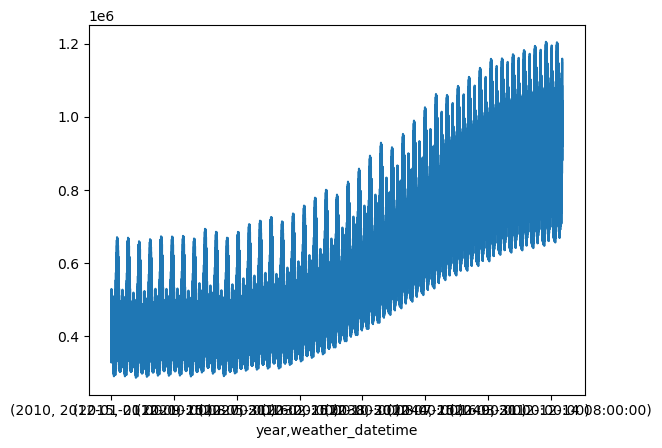

Processing EER_Current_HighDC_UCS_load_hourly.h5
Interpolating annual load
Copying and rescaling load data


2050 : 2050: 100%|██████████| 26/26 [00:01<00:00, 20.72it/s]


Recombining data
Disaggregating states into balancing areas
Converting to xarray
Saving to h5 file


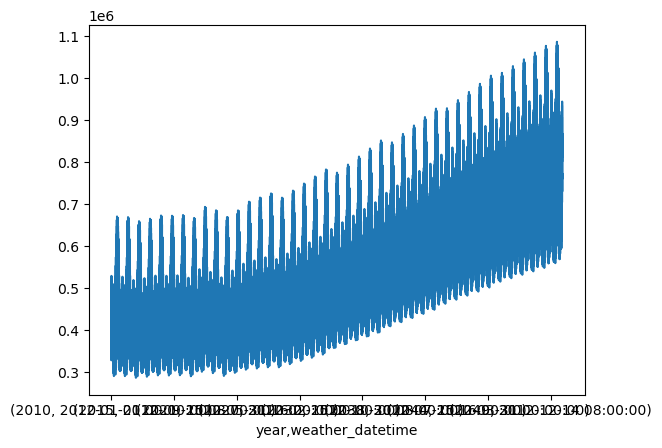

Processing EER_Decarb_HighDC_UCS_load_hourly.h5
Interpolating annual load
Copying and rescaling load data


2050 : 2050: 100%|██████████| 26/26 [00:01<00:00, 20.23it/s]


Recombining data
Disaggregating states into balancing areas
Converting to xarray
Saving to h5 file


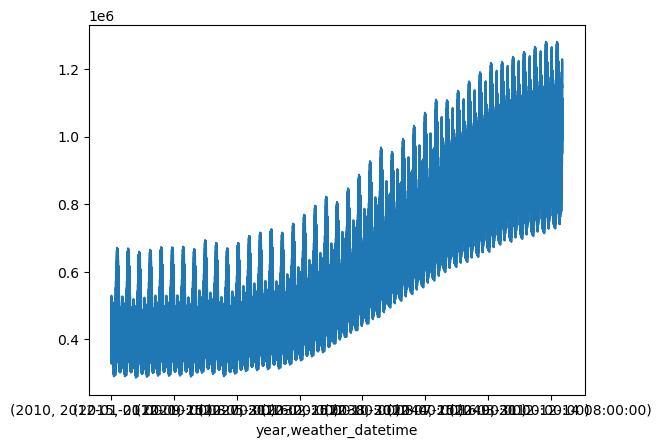

Processing EER_Current_UCS_load_hourly.h5
Interpolating annual load
Copying and rescaling load data


2050 : 2050: 100%|██████████| 26/26 [00:01<00:00, 20.47it/s]


Recombining data
Disaggregating states into balancing areas
Converting to xarray
Saving to h5 file


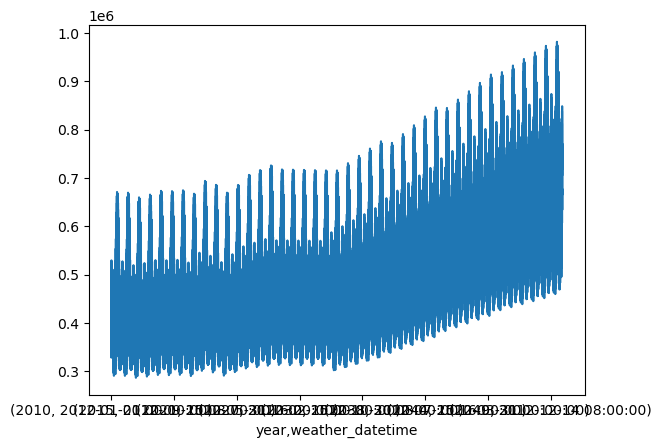

In [297]:
for i, (save_name, dataset) in enumerate(output_name.items()):
    print(f"Processing {save_name}")
    scenario_df = dataset.drop(columns=['scenario', 
                                        'sector',
                                        'subsector']).groupby(['year',
                                                                'weather_datetime']).sum()
    scenario_annual = dataset.drop(columns=['scenario', 
                                            'sector',
                                            'subsector', 
                                            'weather_datetime']).groupby(['year']).sum()
    scenario_annual.index = pd.to_datetime(scenario_annual.index, format='%Y')
    print("Interpolating annual load")
    scenario_annual = scenario_annual.resample('YE').mean().interpolate('linear')

    print("Copying and rescaling load data")
    year_bins = [2025, 2030, 2035, 2040, 2045, 2050]
    frames = []
    pbar = trange(2025, 2051)
    for year in pbar:
        # determine which year to copy
        year_select = year_bins[(np.digitize(year, year_bins)-1)]

        pbar.set_description(f"{year} : {year_select}")
        pbar.update()
        
        subset_copy = scenario_df.loc[(year_select, slice(None)),:].copy()
        # update the index
        subset_copy.index = subset_copy.index.remove_unused_levels().set_levels([year], level=0)
        # print(f"{year} looks like {year_select}")
        for col in subset_copy.columns:
            col_total = subset_copy[col].sum()
            ratio = scenario_annual.at[str(year), col][0] / col_total
            subset_copy[col] = subset_copy[col] * ratio
        
        frames.append(subset_copy[:8760]) # truncate data
    
    print("Recombining data")
    scenario_interpolated = pd.concat(frames)

    print("Disaggregating states into balancing areas")
    combined = scenario_interpolated.copy()
    combined['maryland'] = combined['district of columbia'] + combined['maryland']
    combined = combined.drop(columns=['district of columbia'])
    combined = combined.rename(columns=name_to_abbr)
    combined_disagg = pd.DataFrame({row.ba:(combined[row.state].values\
            *load_participation.loc[load_participation['ba']==row.ba,'factor'].values[0]) 
    for row in county_to_ba.itertuples()})
    combined_disagg.index = scenario_interpolated.index
    scenario_final = pd.concat([df_historical, combined_disagg])

    print("Converting to xarray")
    scenario_xarr = scenario_final.to_xarray()

    print("Saving to h5 file")
    scenario_xarr.to_netcdf(save_name)
    
    # plot 
    scenario_final.sum(axis=1).plot()
    plt.show()
